<a href="https://colab.research.google.com/github/ykhoja/twitter_analysis/blob/master/twitter_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
# Import needed libraries

from google.colab import drive  # to mount Google Drive to Colab notebook
import tweepy                   # Python wrapper around Twitter API
import json
import pandas as pd
import csv
from datetime import date
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
# Mounting Google Drive

drive.mount('/content/gdrive')
path = './gdrive/My Drive/datasets/twitter_analysis/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Twitter Data Collection

## Log into Twitter API

In [0]:
# Load Twitter API secrets from an external file
secrets = json.loads(open(path + 'secrets.json').read())  

consumer_key = secrets['consumer_key']
consumer_secret = secrets['consumer_secret']
access_token = secrets['access_token']
access_token_secret = secrets['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Helper Functions

### Save JSON file

In [0]:
# Helper function to save data into a JSON file
def save_json(file_name, file_content):
  with open(path + file_name, 'w', encoding='utf-8') as f:
    json.dump(file_content, f, ensure_ascii=False, indent=4)

### Twitter API limit handling

In [0]:
# Helper function to handle twitter API rate limit

def limit_handled(cursor, list_name):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print("\nCurrent number of data points in list = " + str(len(list_name)))
            print('Hit Twitter API rate limit.')
            for i in range(3, 0, -1):
              print("Wait for {} mins.".format(i * 5))
              time.sleep(5 * 60)
        except tweepy.error.TweepError:
            print('\nCaught TweepError exception' )

## Data Collection Functions

### Get all tweets

In [0]:
# Helper function to get all tweets for a specified user
# NOTE:  This method only allows access to the most recent 3240 tweets
# Source: https://gist.github.com/yanofsky/5436496

def get_all_tweets(screen_name):

	# initialize a list to hold all the tweepy Tweets
	alltweets = []	
	
	# make initial request for most recent tweets (200 is the maximum allowed count)
	new_tweets = api.user_timeline(screen_name = screen_name,count=200)
	
	# save most recent tweets
	alltweets.extend(new_tweets)
	
	# save the id of the oldest tweet less one
	oldest = alltweets[-1].id - 1
	
	# keep grabbing tweets until there are no tweets left to grab
	while len(new_tweets) > 0:
		print("getting tweets before %s" % (oldest))
		
		# all subsiquent requests use the max_id param to prevent duplicates
		new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
		
		# save most recent tweets
		alltweets.extend(new_tweets)
		
		# update the id of the oldest tweet less one
		oldest = alltweets[-1].id - 1
		
		print("...%s tweets downloaded so far" % (len(alltweets)))
	
	# transform the tweepy tweets into a 2D array that will populate the csv	
	outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count, 
	              tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
	
	# write the csv	
	with open(path + '%s_tweets.csv' % screen_name, 'w') as f:
		writer = csv.writer(f)
		writer.writerow(["id","created_at","text","likes","in reply to","retweeted"])
		writer.writerows(outtweets)
	
	pass

### Get today's twitter stats

In [0]:
# Helper function to get today's numbers of followers and friends and store 
# them into a JSON file

def todays_stats(dict_name):
  info = api.me()
  followers_cnt = info.followers_count
  following_cnt = info.friends_count
  today = date.today()
  d = today.strftime("%b %d, %Y")
  if d not in dict_name:
    dict_name[d] = {"followers":followers_cnt, "following":following_cnt}
    save_json("follower_history.json", dict_name)
  else:
    print('Today\'s stats already exist')

### Get followers data

In [0]:
# Helper function to load follower objects into a list and save it into 
# a JSON file. 

def get_followers():
  followers = []

  for i, page in enumerate(limit_handled(tweepy.Cursor(api.followers, count=200).pages(), followers)):
      print("\r"+"Loading"+ i % 5 *".", end='')
      followers += page

  followers = [x._json for x in followers]
  save_json('followers_data.json', followers)

### Get friends data

In [0]:
# Load friends into list

def get_friends():
  friends = []

  for i, page in enumerate(limit_handled(tweepy.Cursor(api.friends, count=200).pages(), friends)):
      print("\r"+"Loading"+ i % 5 *".", end='')
      friends += page

  friends = [x._json for x in friends]
  save_json('friends_data.json', friends)

## Data Collection Main Script

In [0]:
if __name__ == '__main__':
  #pass in the username of the account you want to download
  get_all_tweets("yakhoja")
  with open(path + 'follower_history.json') as json_file:
    history = json.load(json_file)
  todays_stats(history)
  get_followers()
  get_friends()

getting tweets before 1187233221303386111
...400 tweets downloaded so far
getting tweets before 1176664039721590783
...600 tweets downloaded so far
getting tweets before 1163903890674180096
...800 tweets downloaded so far
getting tweets before 1131070880103030783
...1000 tweets downloaded so far
getting tweets before 1119489695308632063
...1199 tweets downloaded so far
getting tweets before 1104249123379658752
...1399 tweets downloaded so far
getting tweets before 1066927073829150720
...1597 tweets downloaded so far
getting tweets before 586527523011305471
...1597 tweets downloaded so far
Loading....
Current number of data points in list = 3000
Hit API limit. Wait for 5 mins.
Hit API limit. Wait for 5 mins.
Hit API limit. Wait for 5 mins.

Caught TweepError exception
Loading....
Current number of data points in list = 6000
Hit API limit. Wait for 5 mins.
Hit API limit. Wait for 5 mins.
Hit API limit. Wait for 5 mins.

Caught TweepError exception
Loading....
Current number of data point

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'limit_handled' raised StopIteration
  """


Loading..

# Analyzing tweets 

## Load saved data from Google Drive

In [0]:
# Load all saved tweets from @yakhoja
tweets = pd.read_csv(path + 'yakhoja_tweets.csv')

### Classify tweets

In [0]:
# Classify the type of each tweet (i.e. Tweet, Reply, or Retweet)

tweets.retweeted = tweets.text.apply(lambda x: True if 'RT @' in x else False)
tweets['in reply to'] = tweets['in reply to'].fillna('N/A')
tweets['type'] = tweets['in reply to'].apply(lambda x: 'Tweet' if x == "yakhoja" or x == 'N/A' else 'Reply')
tweets.loc[tweets.retweeted, 'type'] = 'Retweet'
tweets.to_csv(path + 'yakhoja_tweets.csv')

In [5]:
# Find the number of tweets in each type
print('Total number of tweets = {}'.format(len(tweets)))
print('\nNumber of tweets by')
tweets.groupby('type').count().id

Total number of tweets = 1597

Number of tweets by


type
Reply      748
Retweet    237
Tweet      612
Name: id, dtype: int64

In [0]:
# Find the average number of likes per tweet type
tweets.groupby('type').mean().likes

type
Reply       1.847594
Retweet     0.000000
Tweet      52.892157
Name: likes, dtype: float64

In [0]:
# Find and print the top 10 tweets by number of likes
top10 = tweets.sort_values('likes',ascending=False)
top10 = top10.reset_index(drop=True)
top10 = top10.head(10)

for i in range(len(top10)):
  print("{}) At {} likes:".format(i+1, top10.likes[i]))
  print(top10.text[i]+"\n")

1) At 2093 likes:
الحمدلله أمس استعملت #الذكاء_الاصطناعي في حل مشكلة شخصية مزمنة كانت عندي....

... الا وهي اني ما اعرف افرق بين البق… https://t.co/4nUf6kaWQN

2) At 1584 likes:
بعض الأمور التي ساعدتني على تنظيم وقتي ومهامي بالعمل

- وضع أهداف للاسبوع
- استعمال تطبيقات لقائمة المهام مثل Trell… https://t.co/ovbt1WnhGR

3) At 1254 likes:
للمهتمين في #تعلم_الآلة ، هذا كتاب من ١٠٠ صفحة فقط يلخص اهم المبادئ الاحصائية و الرياضية و البرمجية مع امثلة و تدري… https://t.co/mglDeysNjB

4) At 1195 likes:
في هذه السلسلة سأوضح كيف تبدأ في مجال تعلم الآلة من خلال منهجية تعالج أكبر 3 صعوبات قد تواجه المتعلم الذاتي حسب نتا… https://t.co/tnTrwpUw52

5) At 1144 likes:
إذا شعرت بالتوتر لأن لديك عدد كبير من المهام ولا تدري أين تبدأ، فأتبع هذه الثلاث خطوات البسيطة

١) عدّد جميع المهام… https://t.co/Rc1TrVrVx2

6) At 1081 likes:
مقال اكثر من رائع يحلل عودة مايكروسوفت للقمة منذ أن تولى ساتيا ناديلا قيادة الشركة في ٢٠١٤

خلال ٢٠١٨ تجاوزت قيمة م… https://t.co/POd5Ouyfcz

7) At 1076 likes:
أطلقت شركة #أمازون مجم

In [0]:
# Find tweets with likes > 49 but < 100
# 49 = the average number of likes my tweets get
# 100 was arbitrarily chosen

tweets[((tweets.likes > 49) & (tweets.likes < 100))].sort_values('likes',ascending=False)

,id,created_at,text,likes,in reply to,retweeted,type
985,1120465979723649026,2019-04-22 23:14:41,الأساسيات المطلوبة\n1) الإحصاء و الإحتمالات: ...,97,yakhoja,False,Tweet
111,1192276908521787392,2019-11-07 03:05:41,هذه تغريدات كتبتها عن التقديم الوظيفي فيها اهم...,95,N/A,False,Tweet
103,1193436702032818177,2019-11-10 07:54:17,وجدت قوقل ٨ صفات لافضل المدراء حسب الدراسة\n\n...,93,yakhoja,False,Tweet
459,1172891741063544833,2019-09-14 15:15:57,تخيل انك في البحر في قارب مثقوب. هل ستتجاهل ال...,85,N/A,False,Tweet
98,1194125191665897472,2019-11-12 05:30:06,مدير #الذكاء_الاصطناعي في @Tesla يتحدث عن كيفي...,84,N/A,False,Tweet
89,1194766231355609088,2019-11-13 23:57:21,اكتشفت كيف اكتب في #بايثون على نفس السطر مع اس...,83,N/A,False,Tweet
538,1170698934081032192,2019-09-08 14:02:31,الآن نشرح اكثر - نبدأ بنبذة عن التعلم الانتقال...,83,yakhoja,False,Tweet
1120,1111377439656050688,2019-03-28 21:20:04,"""لا تجعل المثالية تقف في طريق ما يكفي""\n\nهذه ...",80,N/A,False,Tweet
592,1164339423913267200,2019-08-22 00:52:05,شركة @Waymo (التابعة لقوقل) قامت بتوفير مجموعة...,80,N/A,False,Tweet
83,1195374534079025152,2019-11-15 16:14:32,"I published ""The Grand Cluster Hotel"", a non-t...",79,N/A,False,Tweet


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


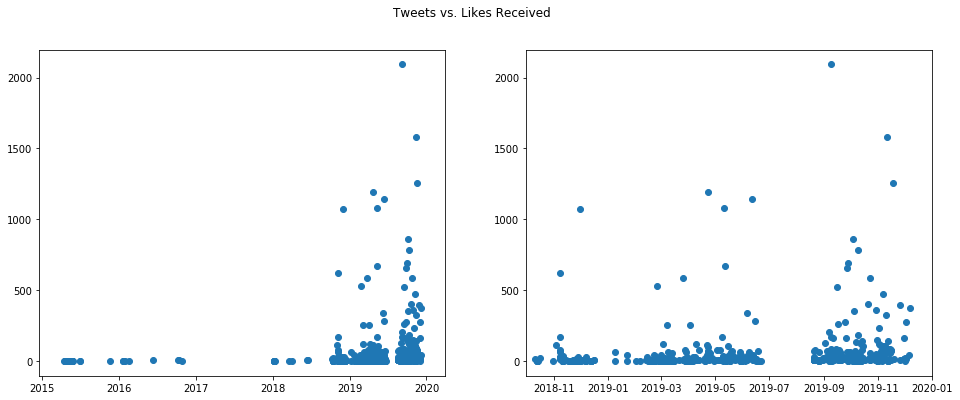

In [8]:
plot_data = tweets[tweets.type == "Tweet"]
plot_data = plot_data[['id','created_at','likes']]
plot_data['time'] = plot_data['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Tweets vs. Likes Received')
ax1.scatter(plot_data.time, plot_data.likes)
ax2.scatter(plot_data.time, plot_data.likes)
left = date(2018, 10, 1)
right = date(2020, 1, 1)
ax2.set_xlim(left=left, right=right);

#Analyzing followers



##Load Saved data from Google Drive

In [0]:
followers = pd.read_json(path + 'followers_data.json') # Followers User ojbects

In [0]:
df = followers

df = df.fillna('Empty')

df = df.replace('','Empty')

In [0]:
# Create list of tags to identify each location
saudi_tags = ['saudi', 'ksa', 'riyadh', 'jeddah', 'makkah', 'madina', 'dammam', 'khobar', 'السعودية', 'السعوديه', 'جدة', 'الرياض', 'الدمام', 'neom', 'eastern', 'riyad', 'riydah', 'med', 'jed',
              'jubail', 'المدينة', 'ابها', 'مكة', 'sa', 'k.s.a', 'qatif', 'medina', 'tabuk', 'dhahran', 'abha', 'hail', 'qassim', 'mecca', 'ruh', 'buraydah', 'الخبر', 'الشرقية', 'الحجاز', 'بريدة', 'القصيم', 'المملكة العربية', 'جده', 'مكه',
              'الحد_الجنوبي', 'الحرمين', 'نجد', 'الرّس', 'j town', 'جازان', 'unayzah', 'الخُبر', 'الظهران', 'تبوك', 'حائل', 'طيبة', 'المجمعة', 'yanbu', 'taif', 'baljurashi', 'الأحساء', 'jeedah', '966', 'suudi', 'أملج', 'اللهم احفظ بلادي', 'الجبيل',
              'سعودية', 'ينبع', 'ryiadh', 'الطائف', 'jdh', 'Alkharj', 'طويق', 'الباحة', 'أم الملح', 'Al Badai', 'البدائع', 'الدرعيه', 'к.ѕ.α', 'المنوره', 'Abu Arish', 'Alkhober', 'rio', '🇸🇦', 'ام الملح', 'فوق هام السحب']

gulf_tags = ['uae', 'kuwait', 'qatar', 'yemen', 'oman', 'bahrain', 'اليمن', 'الإمارات', 'الكويت', 'قطر', 'البحرين', 'عمان', 'abu dhabi', 'q8', 'الجزيره',
             'dubai', 'الامارات', 'مسقط', 'شبه الجزيرة', 'جزيرة العرب', 'al ain', 'kwt', 'u.a.e', 'حضرموت', 'alain', 'arabian island']

mena_tags = ['egypt', 'مصر', 'libya', 'ليبيا', 'iraq', 'العراق', 'sudan', 'syria', 'jordan', 'الأردن', 'morocco', 'tunisia',
             'algeria', 'mauritania', 'palestine', 'فلسطين', 'cairo', 'gaza', 'الوطن العربي', 'Algiers', 'Marrakech', 'Mansoura', 'Algérie', 'amman', 'rafah', 'الاردن', 'لبنان', 'غزة', 'egy', 'eg', 'سوريا', 'حلب', 'الجزائر',
             'khartoum', 'tunis', 'الإسكندرية', 'السودان', 'lebanon', 'irbid', 'Touggourt', 'ramallah', 'سطيف', 'عمّـان', 'الأسكندرية', 'العالم الإسلامي', 'بلد المليون شهيد', 'MENA']

us_tags = ['us', 'united', 'states', 'usa', 'أمريكا', 'los angeles', 'NY', 'IL', 'DC', 'boston', 'stanford', 'philadelphia', 'CT', 'new orleans', 'miami', 'u.s.a', 'omaha',
           'new york', 'manhattan', 'mn', 'menlo park', 'wa', 'az', 'sf', 'tx', 'pa', 'or', 'portola valley', 'bay area', 'cambridge', 'va', 'fl', 'ga', 'lincoln', 'irvine', 'detroit', 'halifax',
           'ohio', 'nm', 'تكساس', 'co', 'oh', 'nc', 'الامريكية', 'cypress', '92108', 'West Lafayette', 'Utah']

uk_tags = ['uk', 'london', 'leeds', 'new castle', 'manchester', 'liverpool', 'england', 'ireland', 'scotland', 'glasgow']

euro_tags = ['paris', 'france', 'spain', 'munich', 'italy', 'netherlands', 'nederland', 'Deutschland', 'germany', 'berlin', 'finland', 'switzerland', 'sweden', 'stuttgart', 'Malmö', 'Sverige', 'Rotterdam']

canada_tags =['canada', 'british columbia', 'ontario', 'Montréal', 'calgary']

turkey_tags =['turkey', 'Türkiye']

# Create logical masks to clean up data
saudi = df.location.str.contains('|'.join(saudi_tags), case=False)
gulf = df.location.str.contains('|'.join(gulf_tags), case=False)
mena = df.location.str.contains('|'.join(mena_tags), case=False)
us = df.location.str.contains('|'.join(us_tags), case=False)
uk = df.location.str.contains('|'.join(uk_tags), case=False)
euro = df.location.str.contains('|'.join(euro_tags), case=False)
canada = df.location.str.contains('|'.join(canada_tags), case=False)
turkey = df.location.str.contains('|'.join(turkey_tags), case=False)
empty = df.location.str.contains('Empty')
other = saudi | gulf | mena | us | uk | euro | canada | turkey | empty
other = ~other

# Clean up data
df.loc[gulf, 'location'] = 'Gulf'
df.loc[mena, 'location'] = 'MENA'
df.loc[us, 'location'] = 'US'
df.loc[uk, 'location'] = 'UK'
df.loc[euro, 'location'] = 'Europe'
df.loc[canada, 'location'] = 'Canada'
df.loc[turkey, 'location'] = 'Turkey'
df.loc[saudi, 'location'] = 'Saudi Arabia'
df.loc[empty, 'location'] = 'Empty'
df.loc[other, 'location'] = 'Other'

print('Number of unique locations before clean up: ' + str(len(followers.location.unique())))
print('Number of unique locations after clean up: ' + str(len(df.location.unique())))

Number of unique locations before clean up: 2281
Number of unique locations after clean up: 10


In [0]:
print('Total number of followers: {}\n'.format(len(followers)))

print('Followers by')
df.groupby('location').count().sort_values('id',ascending=False).id

Total number of followers: 9927

Followers by


location
Empty           4446
Saudi Arabia    3654
US               617
Other            609
MENA             239
Gulf             164
UK               100
Europe            56
Canada            24
Turkey            18
Name: id, dtype: int64

In [0]:
# List the unique locations under Other

ids = df[df.location == 'Other'].id
followers[followers.id.isin(ids)].location.unique()

array(['     ', 'Algerie', "The sky's our limits", 'The Sky', 'Ey',
       'الشارقة', 'Atlanta', 'Sky', 'unbounded ', 'Web',
       'Tanger - Tétouan, Royaume du M', 'Ras Tannurah',
       'التواصل والأسعـــــار والنماذج والتفاصيل في وتساب فقط 00971505673307',
       'Snapchat: rbdis', '( إلى ربك يومئذ المستقر ) ',
       'بين صفحات العروض ..', 'ارض الريتويت', 'Kosovo', 'Kalba',
       '(Transit in الدنيا)', 'EVERYWhere', ' Planet Earth',
       'ولكم في الأرض مستقر', 'الاحق رزقي', 'KAU',
       'هدفي في الحياة رضا الله اولا ', '.', '127.0.0.1',
       'كوكب الأرض حالياً', '♫', '  ', 'Home', 'Riydh',
       'in middle of nowhere', 'يارب رُدني إليك رداً جميلا', '🎼',
       'واق الواق', 'Somewhere on planet EARTH.', '“قدر قيمة الحياة.”',
       'My Room ', 'earth', 'Microsoft', 'في غمرة العابرين!', '210 | 512',
       'Earth ', 'over there', 'Online💡', 'Think Different',
       'Here, There and Everywhere', 'Honolulu, HI', 'Neverland',
       'من #زمن_الطيبين ', 'في ربوع وطني', '\U0001f9

In [0]:
print("Number of followers who have more than 30k followers: {}".format(len(df.loc[df.followers_count >= 3e4])))
print('Number of verified followers: {}'.format(len(df[df.verified == True])))

Number of followers who have more than 30k followers: 58
Number of verified followers: 31


#Analyzing following


## Load Saved Data from Google Drive

In [0]:
following = pd.read_json(path + 'friends_data.json')       # Friends User ojbects

In [0]:
df = following

df = df.fillna('Empty')

df = df.replace('','Empty')

In [0]:
# Create list of tags to categorize following
saudi_gov_url_tags =['.gov.sa', 'neom', 'qiddiya', '.sa', '.com.sa']
saudi_gov_bio_tags = ['وزير', 'نائب مدير', 'وكيل', 'وزارة', 'محافظ', 'هيئة', 'مدير']
academic_url_tags =['.edu']
academic_bio_tags =['prof', 'professor', 'research', 'أستاذ']
vc_tags =  ['fund', 'vc', 'partner', 'investor', 'venture', 'gp']
ai_tags =  ['ai', 'ml', 'deep learning', 'machine learning', 'vision', 'keras', 'tensorflow', 'Data Scientist', 'Data Science', 'nlp', 'xgboost', 'علم البيانات']
product_tags =  ['product', 'cpo', 'design', 'PM']
fitness_tags = ['fitness', 'muscle', 'nba']
ceo_tags = ['ceo', 'الرئيس التنفيذي']
magazine_tags =  ['forbes', 'techcrunch', 'inc', 'nat geo', 'harvardbiz', 'engadget', 'freakonomics', 'tedtalks', 'reutersbiz', 'huffpost', 
                  'wsj', 'business', 'theeconomist', 'bw', 'businessinsider', 'cnn', 'time', 'popmech', 'Entrepreneur', 'fastcompany', 'alarabiya']
writer_tags =  ['writer', 'editor', 'author', 'journalist', 'skinny canadian', 'news', 'report', 'cover', 'كاتب', 'صحفي', 'أكتب', 'writing', 'correspondent']
energy_tags = ['energy', 'exxon', 'أرامكو']
startup_tags = ['founder', 'yc', 'ycw', 'co-founder', 'مؤسس']
programmer_tags = ['developer', 'software', 'linux', 'hacker', 'هاكر', 'مطور', 'مبرمج', '.net', 'php', 'laravel', 'gnu', 'engineer', 'cto']


# Create logical masks to clean up data

# Based on URL
saudi_gov_url = df['url'].str.contains('|'.join(saudi_gov_url_tags), case=False)
academic_url = df['url'].str.contains('|'.join(academic_url_tags), case=False)

# Based on twitter profile bio
saudi_gov_bio = df['description'].str.contains('|'.join(saudi_gov_bio_tags), case=False)
academic_bio = df['description'].str.contains('|'.join(academic_bio_tags), case=False)
vc = df['description'].str.contains('|'.join(vc_tags), case=False)
ai = df['description'].str.contains('|'.join(ai_tags), case=False)
product = df['description'].str.contains('|'.join(product_tags), case=False)
writer = df['description'].str.contains('|'.join(writer_tags), case=False)
fitness = df['description'].str.contains('|'.join(fitness_tags), case=False)
energy = df['description'].str.contains('|'.join(energy_tags), case=False)
startup = df['description'].str.contains('|'.join(startup_tags), case=False)
ceo = df['description'].str.contains('|'.join(ceo_tags), case=False)
programmer = df['description'].str.contains('|'.join(programmer_tags), case=False)

# Based on twitter ID
magazine = df['screen_name'].str.contains('|'.join(magazine_tags), case=False)

# Based on a combination 
saudi_gov = saudi_gov_url | saudi_gov_bio
academic = academic_url | academic_bio
media = writer | magazine

# Clean up data
df.loc[saudi_gov, 'Category'] = 'Saudi Gov'
df.loc[academic, 'Category'] = 'Academic'
df.loc[vc, 'Category'] = 'VC'
df.loc[ai, 'Category'] = 'AI'
df.loc[product, 'Category'] = 'Product'
df.loc[media, 'Category'] = 'Media (writer/magazine)'
df.loc[fitness, 'Category'] = 'Fitness'
df.loc[energy, 'Category'] = 'Energy'
df.loc[startup, 'Category'] = 'Startup'
df.loc[ceo, 'Category'] = 'CEO'
df.loc[programmer, 'Category'] = 'Programmer'
df.fillna('Other',inplace=True)

In [0]:
print('Total number of users I\'m following: {}\n'.format(len(following)))

print('Following by')
df.groupby('Category').count().id.sort_values(ascending=False)

Total number of users I'm following: 1470

Following by


Category
Other                      399
Programmer                 225
AI                         168
Media (writer/magazine)    162
Startup                    124
Product                     96
CEO                         88
VC                          70
Saudi Gov                   55
Energy                      36
Academic                    33
Fitness                     14
Name: id, dtype: int64

In [0]:
# List the users under Other

ids = df[df.Category == 'Other'].id
following[following.id.isin(ids)][['screen_name','description']]

,screen_name,description
4,JeddahAmanah,الحساب الرسمي لـ #أمانة_جدة | للطوارئ والبلاغا...
7,makkahregion,حساب إخباري لـ #إمارة_مكة للتواصل: prjeddah@ma...
10,g20org,The Official Account of #G20SaudiArabia\nالحسا...
16,taqa_sa,الحملة الوطنية لترشيد استهلاك الطاقة #لتبقى.. ...
21,SaudiBanks,الحساب الرسمي للجنة الاعلام والتوعية المصرفية ...
...,...,...
1423,BillGates,Sharing things I'm learning through my foundat...
1429,HashKSA,الآن،، جوالنا المجاني حصريًا على STC أرسل 1 لل...
1430,spagov,الحساب الرسمي لـ واس الخاص بأخبار خادم الحرمين...
1431,JosephEStiglitz,"The official account of Joseph E. Stiglitz, No..."


In [0]:
# Unfollow all users in the fitness category

fitness_df = df[df.Category == 'Fitness']

for _, row in fitness_df.iterrows():    # iterate over rows in the fitness data
  api.destroy_friendship(row['id'])     # use twitter api to unfollow based on id

# Analyzing History

## Load Saved Data from Google Drive

In [0]:
history = pd.read_json(path + 'follower_history.json').transpose()     # Follower history dictionary
dates = history.index.strftime('%b %d')

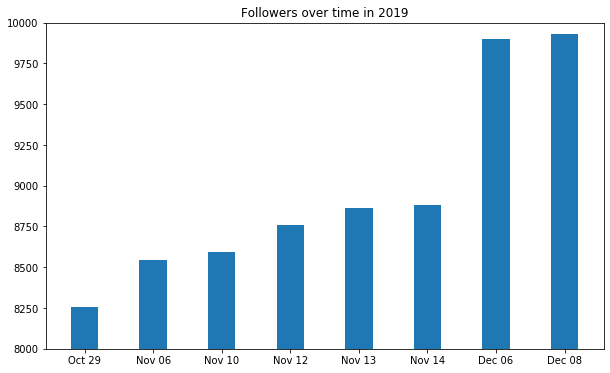

In [0]:
# Plot the number of my followers over time

plt.bar(dates, history.followers, figure=plt.figure(figsize=(10,6)), width=0.4);
plt.ylim(8000, 1e4);
plt.title('Followers over time in 2019');

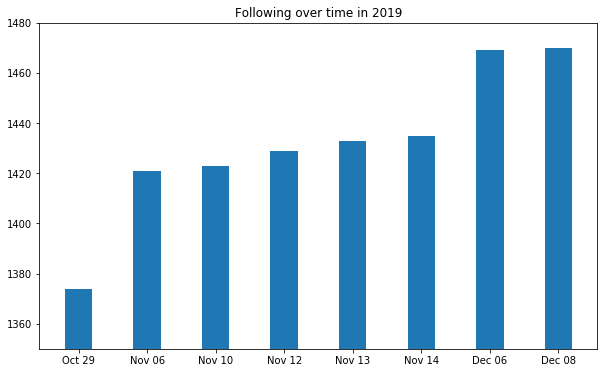

In [0]:
# Plot number of users I'm following over time

plt.bar(dates, history.following, figure=plt.figure(figsize=(10,6)), width=0.4);
plt.ylim(1.35e3, 1.48e3);
plt.title('Following over time in 2019');